In [77]:
# Standard Imports
import os
import numpy as np
import pandas as pd
import sys

# modelling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Src modules
sys.path.append(os.path.dirname(os.getcwd())) # Add the parent directory to the Python path so we can import src modules
from src.data_setup import get_data, get_daily_sales, get_oil_holiday_data, RAW_PATH
from src.model_evaluation import model_eval_pipeline


# 1. Data Loading and Processing

In [19]:
# load in dataframes
train, test, stores, transactions = get_data()

loading pickled dataframes...


In [20]:
# merge stores data into train
train = train.merge(stores, on ='store_nbr')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   store_nbr         int8          
 2   family            object        
 3   sales             float32       
 4   onpromotion       float32       
 5   year              int32         
 6   month             int8          
 7   week              int8          
 8   day_of_week       int8          
 9   day_of_month      int8          
 10  day_of_year       int16         
 11  week_of_month     int8          
 12  is_wknd           int8          
 13  quarter           int8          
 14  is_month_start    int8          
 15  is_month_end      int8          
 16  is_quarter_start  int8          
 17  is_quarter_end    int8          
 18  is_year_start     int8          
 19  is_year_end       int8          
 20  season            int8          
 21  city    

In [21]:
assert train.isnull().sum().sum() == 0
print('no null values in the training data')

no null values in the training data


In [23]:
assert train.duplicated().any() == False
print('no duplicate values in the training data')

no duplicate values in the training data


In [24]:
train.describe()

,store_nbr,sales,onpromotion,year,month,week,day_of_week,day_of_month,day_of_year,week_of_month,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,cluster
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00,2.014838e+03,6.207838e+00,2.524287e+01,3.997031e+00,1.563005e+01,1.733890e+02,2.685867e+00,4.281473e-01,2.410333e+00,3.325416e-02,3.266033e-02,1.128266e-02,1.068884e-02,2.969121e-03,2.375297e-03,1.448931e+00,8.481481e+00
std,1.558579e+01,1.093292e+03,1.208813e+01,1.342275e+00,3.385668e+00,1.479467e+01,2.000740e+00,8.794789e+00,1.034388e+02,1.267824e+00,4.948103e-01,1.099952e+00,1.792995e-01,1.777460e-01,1.056190e-01,1.028328e-01,5.440870e-02,4.867911e-02,1.083401e+00,4.649735e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,2.014000e+03,3.000000e+00,1.300000e+01,2.000000e+00,8.000000e+00,8.500000e+01,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00,2.015000e+03,6.000000e+00,2.500000e+01,4.000000e+00,1.600000e+01,1.690000e+02,3.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.500000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00,2.016000e+03,9.000000e+00,3.800000e+01,6.000000e+00,2.300000e+01,2.592500e+02,4.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.300000e+01
max,5.400000e+01,1.247170e+05,7.410000e+02,2.017000e+03,1.200000e+01,5.300000e+01,7.000000e+00,3.100000e+01,3.660000e+02,5.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.700000e+01


In [25]:
train.head()

,date,store_nbr,family,sales,onpromotion,year,month,week,day_of_week,day_of_month,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,2013,1,1,2,1,...,0,1,0,1,0,0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.0,0.0,2013,1,1,2,1,...,0,1,0,1,0,0,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.0,0.0,2013,1,1,2,1,...,0,1,0,1,0,0,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.0,0.0,2013,1,1,2,1,...,0,1,0,1,0,0,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.0,0.0,2013,1,1,2,1,...,0,1,0,1,0,0,Quito,Pichincha,D,13


# 2. Data Testing and Preparation before ARIMA

Before running an ARIMA model, one must run certain tests to ensure the data is autocorrelated and stationary, in adition to preparing it for the model. 

**Resources:**
 * [TDS - Time series Forecasting — ARIMA models](https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06)

In [109]:
# this arima model will be looking at daily sales so we have to aggregate away from store number and family
daily_sales = train.groupby('date')['sales'].sum().reset_index()
print(len(daily_sales))
daily_sales.head()

1684


,date,sales
0,2013-01-01,2511.618896
1,2013-01-02,496092.406250
2,2013-01-03,361461.218750
3,2013-01-04,354459.687500
4,2013-01-05,477350.125000


## Autocorrelation
Auto-Correlation Function(ACF) - Correlation between the original data and the same data lagged by ‘h’ time period

Normally in an ARIMA model, we make use of either the AR term or the MA term. We use both of these terms only on rare occasions. We use the ACF plot to decide which one of these terms we would use for our time series

If there is a Positive autocorrelation at lag 1 then we use the AR model

If there is a Negative autocorrelation at lag 1 then we use the MA model

In [110]:
# lag of one
sales_series = daily_sales['sales']
print(f'{sales_series.autocorr():.4f}')

0.7669


because the autocorr coefficient is positive for lag 1 we will use an autoregressive model.  

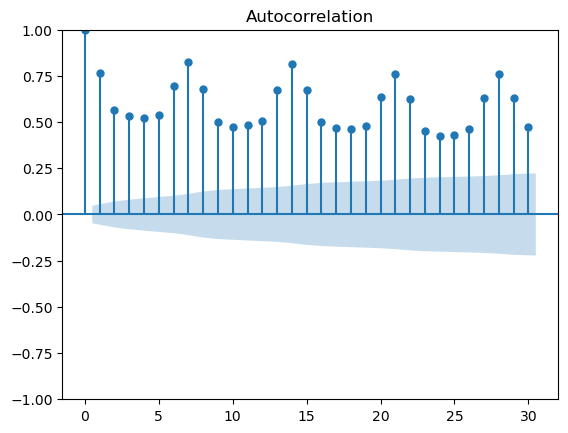

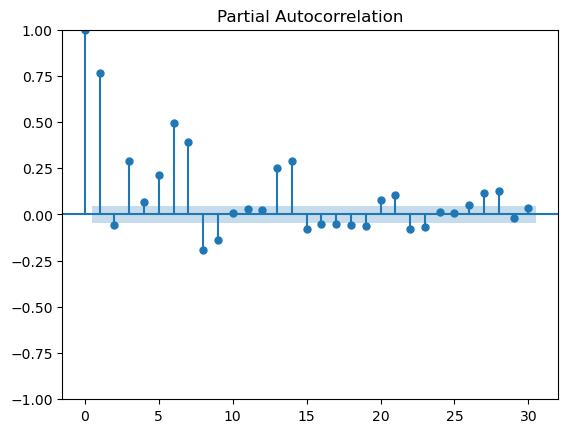

In [127]:
acf = plot_acf(sales_series, lags=30)
pacf = plot_pacf(sales_series, lags=30, method='ywm')   # added method to get rid of a future warning

## Stationarity Test

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. 

Stationary time series is when the mean and variance are constant over time. It is easier to predict when the series is stationary.

Differencing is a method of transforming a non-stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model.

H0: the data is not stationary (mean and variance are not constant over time)
H1: the data is stationary (mean and variance are constant over time)

In [114]:
def plot_rolling_average_stdev(time_series, col='sales', windowsize=7):
    df = time_series.copy()
    # Calculate rolling average and rolling standard deviation
    df['rolling_average'] = df[col].rolling(windowsize).mean()
    df['rolling_std'] = df[col].rolling(windowsize).std()

    # Create the line plot with rolling average and rolling standard deviation
    fig = go.Figure()
    fig.add_scatter(x=df['date'], y=df['rolling_average'], name='Rolling Average')
    fig.add_scatter(x=df['date'], y=df['rolling_std'], name='Rolling Standard Deviation')
    fig.update_layout(title='Rolling Average and Standard Deviation')
    fig.show()

In [115]:
def eval_hypothesis_test(hypotheses, p_value, alpha=0.05):
    if p_value < alpha:
        print(f'Reject the null hypothesis, accept alternate hypothesis: "{hypotheses[1]}" (p-value: {p_value:.4f})')
    else:
        print(f'Fail to reject the null hypothesis: "{hypotheses[0]}" (p-value: {p_value:.4f})')

In [116]:
# visualise the rolling average and standard deviation of the daily sales
plot_rolling_average_stdev(daily_sales)


In [117]:
df_hypotheses = [
    'data is not stationary',   # null hypothesis
    'data is stationary'        # alternate hypothesis
]
# Dickey-Fuller Test for Stationarity
dickey_fuller = adfuller(sales_series)
eval_hypothesis_test(df_hypotheses, dickey_fuller[1])

Fail to reject the null hypothesis: "data is not stationary" (p-value: 0.0897)


Since we fail to reject the null hypothesis, we perform differencing until the data is stationary

In [122]:
daily_sales['diff_sales'] = daily_sales['sales'].diff()
daily_sales = daily_sales.dropna()

In [128]:
plot_rolling_average_stdev(daily_sales, col='diff_sales')

The rolling agerage and standard deviation are visually more constant now

In [129]:
dickey_fuller = adfuller(daily_sales['diff_sales'])
eval_hypothesis_test(df_hypotheses, dickey_fuller[1])

Reject the null hypothesis, accept alternate hypothesis: "data is stationary" (p-value: 0.0000)


The data is now stationary so we can proceed with the modelling. First lets review the autocorrelation plots on the differenced data. 

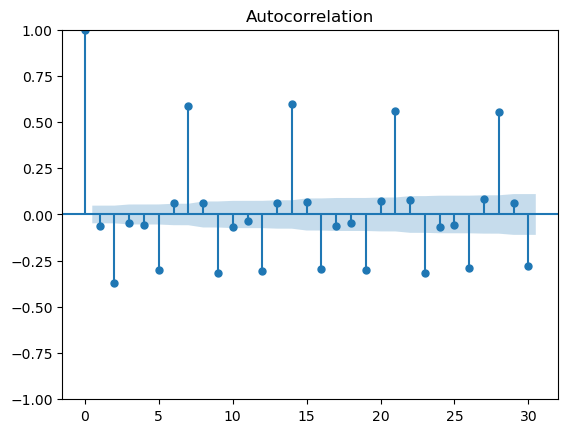

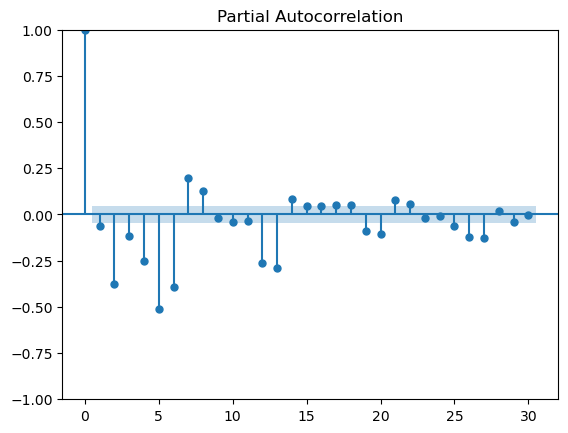

In [130]:
acf = plot_acf(daily_sales['diff_sales'], lags=30)
pacf = plot_pacf(daily_sales['diff_sales'], lags=30, method='ywm')   # added method to get rid of a future warning

Autocorrelation has peaks every 7 days, which makes sense that the data would have a weekly trend. 

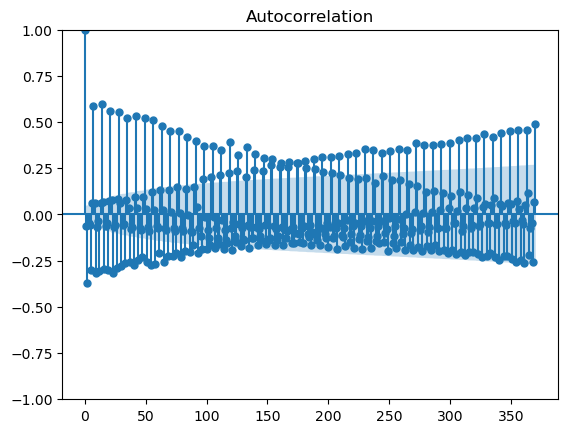

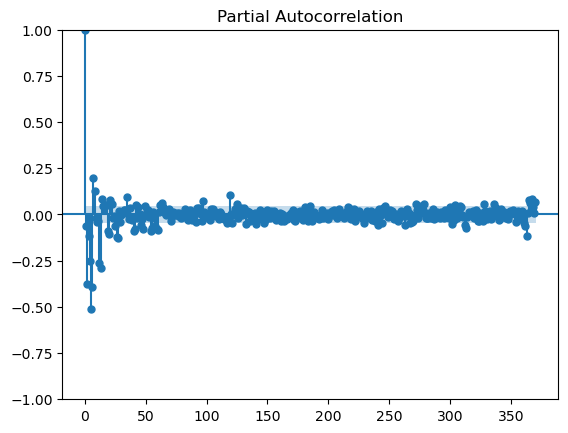

In [132]:
acf = plot_acf(daily_sales['diff_sales'], lags=370)
pacf = plot_pacf(daily_sales['diff_sales'], lags=370, method='ywm')   # added method to get rid of a future warning

In [131]:
train.family.nunique()

33

In [ ]:
p = 1
